# Example notebook for classification analysis

This notebook contains an example analysis of WatChMaL classification runs, including comparison to fiTQun reconstruction.

Plots are included of the training progression, ROC curves, and various plots of signal or background efficiency vs physical quantities.

## Imports and setup

First change some display settings for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

External imports:

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py
import tabulate

In [4]:
# either add WatChMaL repository directory to PYTHONPATH environment variable or add it here
sys.path.append('/home/Antoine.m/WatChMaL')
sys.path.append('/home/Antoine.m')

Import WatChMaL analysis code

In [5]:
import analysis.utils.math as math
from analysis.utils.binning import get_binning, apply_binning
from analysis.utils.plotting import plot_legend
from analysis.classification import WatChMaLClassification, FiTQunClassification, plot_rocs, plot_efficiency_profile, combine_softmax
from analysis.read import FiTQunOutput

/home/Antoine.m/WatChMaL/analysis/__init__.py:4: UserWarning: WARNING: The git repository has uncommitted changes. Please commit changes before running WatChMaL code for proper version control
  print(f"Imported analysis code from WatChMaL repository with git version: {get_git_version(os.path.dirname(__file__))}")


Imported analysis code from WatChMaL repository with git version: bd90b0e-dirty


# Preparing data

In [6]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

## Get true particle data from h5 file

In [7]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

In [8]:
# get indices of test events
idxs_path = '/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
test_idxs  =  np.load(idxs_path, allow_pickle=True)['test_idxs']

### Open H5 data

In [9]:
# open h5 file and get data for test events
data_path = "/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
h5_nhits      = (events_hits_index[test_idxs+1] - events_hits_index[test_idxs]).squeeze()

In [10]:
h5_directions = math.direction_from_angles(h5_angles)

# Plotting fiTQun and ResNet performance

## Set up plotting style

In [11]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
rcparams = {
    "font.sans-serif": ["TeX Gyre Heros", "Helvetica", "Arial"],
    "font.family": "sans-serif",
    "mathtext.fontset": "custom",
    "mathtext.rm": "TeX Gyre Heros",
    "mathtext.bf": "TeX Gyre Heros:bold",
    "mathtext.sf": "TeX Gyre Heros",
    "mathtext.it": "TeX Gyre Heros:italic",
    "mathtext.tt": "TeX Gyre Heros",
    "mathtext.cal": "TeX Gyre Heros",
    "mathtext.default": "regular",
    "figure.figsize": (10.0, 10.0),
    "font.size": 26,
    "axes.labelsize": "medium",
    "axes.unicode_minus": False,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "legend.fontsize": "small",
    "legend.handlelength": 1.5,
    "legend.borderpad": 0.5,
    "legend.frameon": False,
    "xtick.direction": "in",
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,
    "grid.alpha": 0.8,
    "grid.linestyle": ":",
    "axes.linewidth": 2,
    "savefig.transparent": False,
    "xaxis.labellocation": "right",
    "yaxis.labellocation": "top",
}
for key in list(rcparams.keys()):
    matplotlib.rcParams[key] = rcparams[key]
# matplotlib.rcParams['figure.figsize'] = (12, 9)
# matplotlib.rcParams["figure.autolayout"] = True

## Make some cuts to select the events of interest

In [12]:
h5_towall = math.towall(h5_positions, h5_angles)
h5_dwall = math.dwall(h5_positions)
h5_momentum = math.momentum_from_energy(h5_energies, h5_labels)

od_veto_cut = (h5_vetos == 0)
dwall_cut = h5_dwall > 50
towall_cut = h5_towall > 100
nhit_cut = h5_nhits > 25

h5_gammas = (h5_labels==0)
h5_electrons = (h5_labels==1)
h5_muons = (h5_labels==2)

# select the true electron and muon events that pass the cuts
cuts = ((h5_electrons | h5_muons)
        & od_veto_cut
        & nhit_cut
       )

## Bin events in various quantities

Here we use the binning functions that allow us to bin events by various quantities:

In [13]:
help(get_binning)

Help on function get_binning in module analysis.utils.binning:

get_binning(x, bins=None, minimum=None, maximum=None, width=None)
    Finds the indices of the bins to which each value in input array belongs, for a set of bins specified either as an
    array of bin edges, number of bins or bin width
    
    Parameters
    ----------
    x: array_like
        Input array to be binned.
    bins: array_like, optional
        If `bins` is an int, it defines the number of equal-width bins in the range (200, by default). If `bins` is an
        array, it is the array of bin edges and must be 1-dimensional and monotonic.
    minimum: int or real, optional
        Lowest bin lower edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    maximum: int or real, optional
        Highest bin upper edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    width: int or real, optional
        Width of bins to generate equal w

In [14]:
mom_binning = get_binning(h5_momentum, 17, 150, 1000)
cos_zenith_binning = get_binning(np.cos(h5_angles[:,0]), 20, -1, 1)
azimuth_binning = get_binning(h5_angles[:,1]*180/np.pi, 20, -180, 180)
dwall_binning = get_binning(h5_dwall, 22, 50, 300)
towall_binning = get_binning(h5_towall, 30, 50, 800)

# Electron vs muon

## Load results
### Load ResNet and fiTQun results

Here we set up an instance of the classification class for WatChMaL outputs:

In [17]:
vmdls_run = WatChMaLClassification("/home/Antoine.m/WatChMaL/outputs/2023-05-12/11-48-46", "VMDLS",
                                    h5_labels, test_idxs, cuts, color="blue", linestyle='-')
resnet_run = WatChMaLClassification("/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/WatChMaL/outputs/2022-06-13/09-25-53", "Resnet",
                                    h5_labels, test_idxs, cuts, color="red", linestyle='-')

### Plot training progression

OSError: /home/lbidulka/WatChMaL/outputs/2022-06-11/16-44-58/outputs/log_val.csv not found.

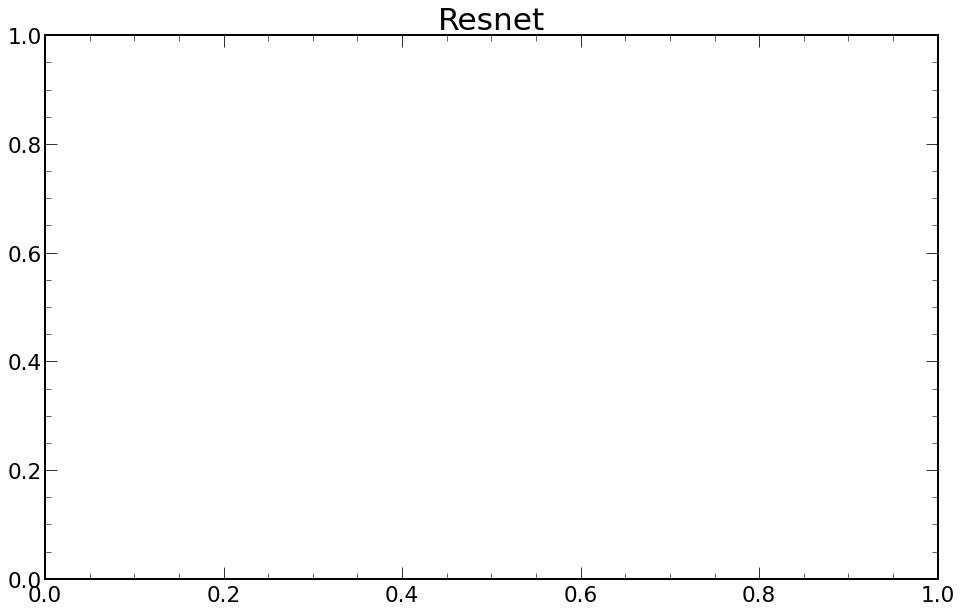

In [18]:
fig, ax1, ax2, = resnet_run.plot_training_progression(legend=None, fig_size=(16,10), title=resnet_run.run_label)
leg_fig, leg_ax = plot_legend((ax1, ax2))

## Plot results

### Plot histograms of the predicted probabilities
For electron vs muon probabilities, in a 4-class model with gammas (which are also considered electron-like) we need to combine the electron and gamma softmaxes to get the electron-like probability.
The discriminator method used below automatically calulates the signal probability from the softmax values of the given signal and background labels.

In [ ]:
help(WatChMaLClassification.discriminator)

Help on function discriminator in module analysis.classification:

discriminator(self, signal_labels, background_labels)
    Return a discriminator with appropriate scaling of softmax values from multi-class training, given the set of
    signal and background class labels. For each event, the discriminator is the sum the signal softmax values
    normalised by the sum of signal and background softmax values.
    
    Parameters
    ----------
    signal_labels: int or sequence of ints
        Set of labels corresponding to signal classes. Can be either a single label or a sequence of labels.
    background_labels: int or sequence of ints
        Set of labels corresponding to background classes. Can be either a single label or a sequence of labels.
    
    Returns
    -------
    np.ndarray
        One-dimensional array of discriminator values, with length equal to the number of events in this run.



In [ ]:
e_labels = [0,1]
mu_labels = [2]
e_probabilities_resnet = resnet_run.discriminator(e_labels, mu_labels)
mu_probabilities_resnet = resnet_run.discriminator(e_labels, mu_labels)
e_probabilities_vmdls = vmdls_run.discriminator(e_labels, mu_labels)
mu_probabilities_vmdls = vmdls_run.discriminator(e_labels, mu_labels)

Text(0.5, 1.0, 'Resnet muon/electron discriminator')

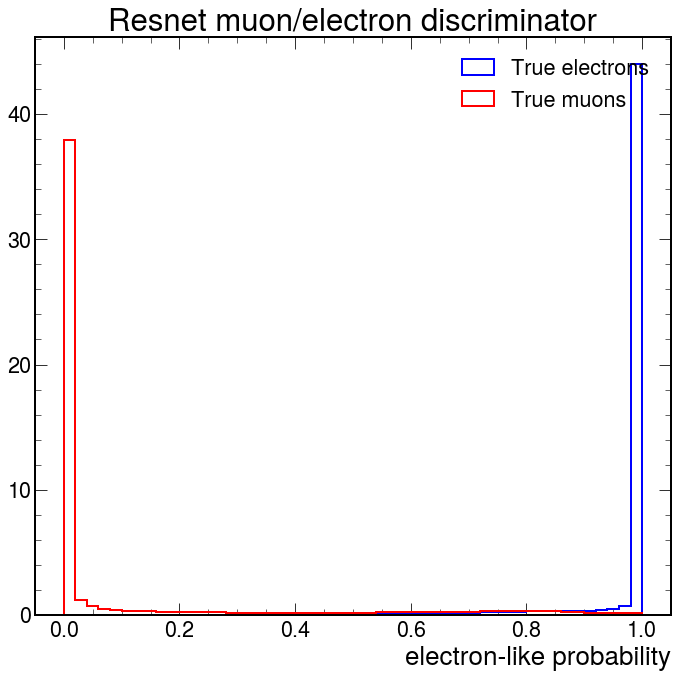

In [ ]:
fig, ax = plt.subplots()
ax.hist(e_probabilities_resnet[h5_electrons], density=True, histtype='step', lw=2, color='blue', bins=50, label='True electrons')
ax.hist(e_probabilities_resnet[h5_muons], density=True, histtype='step', lw=2, color='red', bins=50, label='True muons')
ax.set_xlabel("electron-like probability")
ax.legend(loc='best')
plt.title("Resnet muon/electron discriminator")

Text(0.5, 1.0, 'VMDLS muon/electron discriminator')

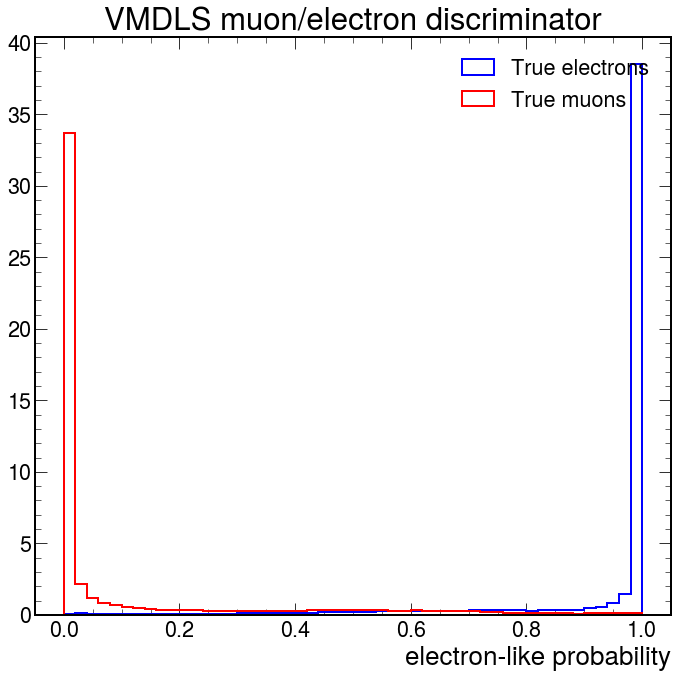

In [ ]:
fig, ax = plt.subplots()
ax.hist(e_probabilities_vmdls[h5_electrons], density=True, histtype='step', lw=2, color='blue', bins=50, label='True electrons')
ax.hist(e_probabilities_vmdls[h5_muons], density=True, histtype='step', lw=2, color='red', bins=50, label='True muons')
ax.set_xlabel("electron-like probability")
ax.legend(loc='best')
plt.title("VMDLS muon/electron discriminator")

### ROC curve for electron signal vs muon rejection

The `plot_rocs` function allows plotting overlaid ROC curves for a chosen signal and background classification.

We plot using a few different formats for viewing the ROC data.

Note that in several of the plotting functions, we pass a list of runs (here just containing a single run, i.e. `[resnet_run]`). To make plots comparing multiple classification runs, for example with different network architectures or hyperparameters, you can simply replace this with a list containing more than one run.

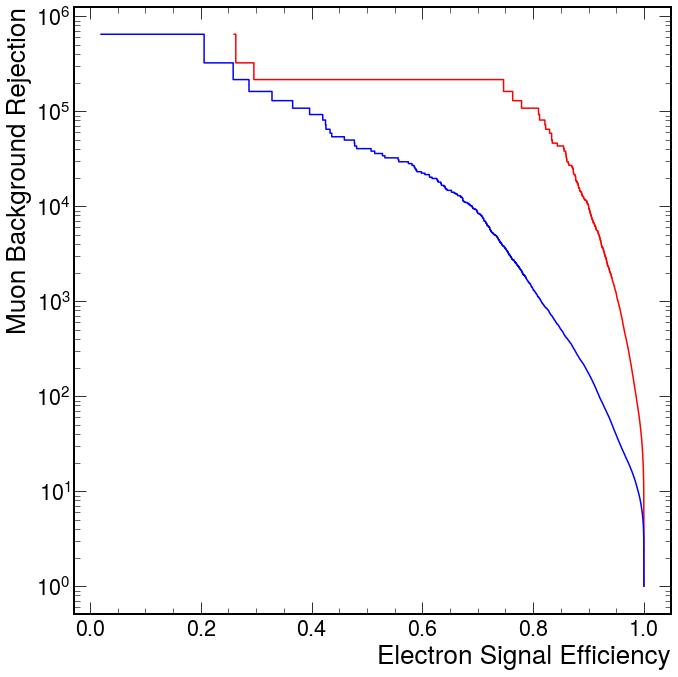

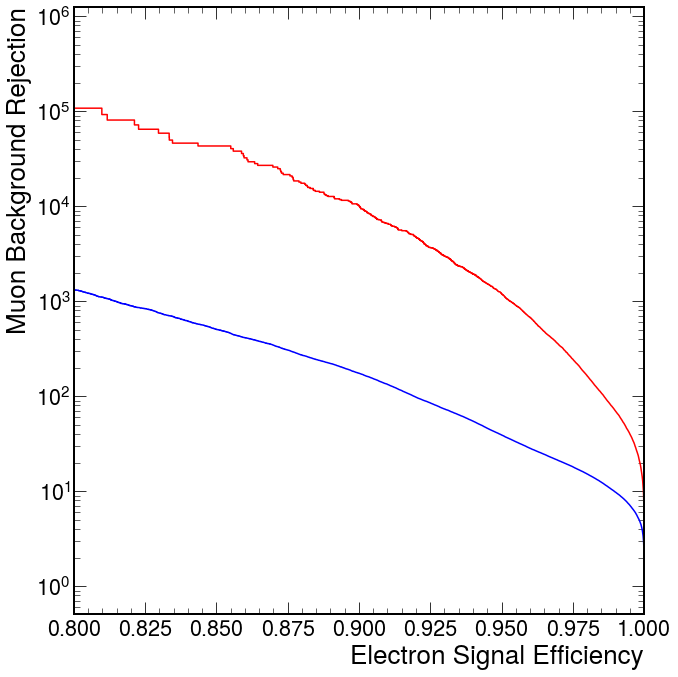

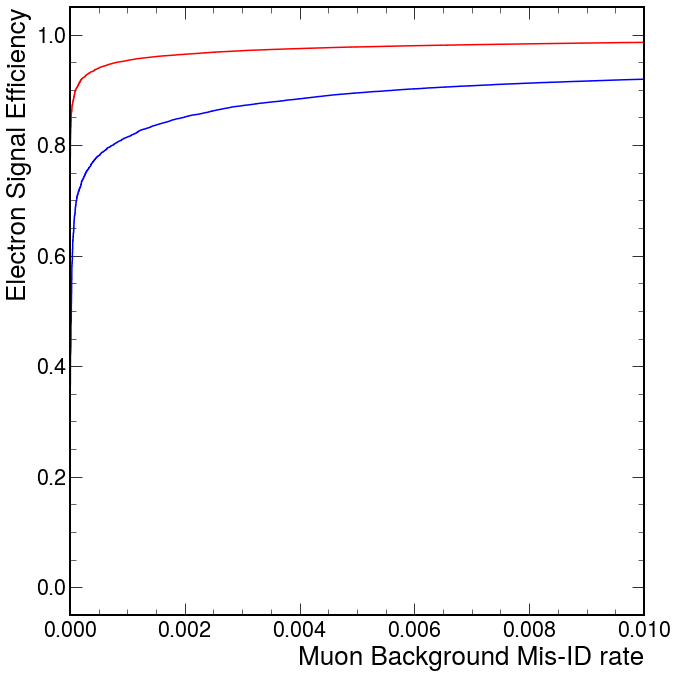

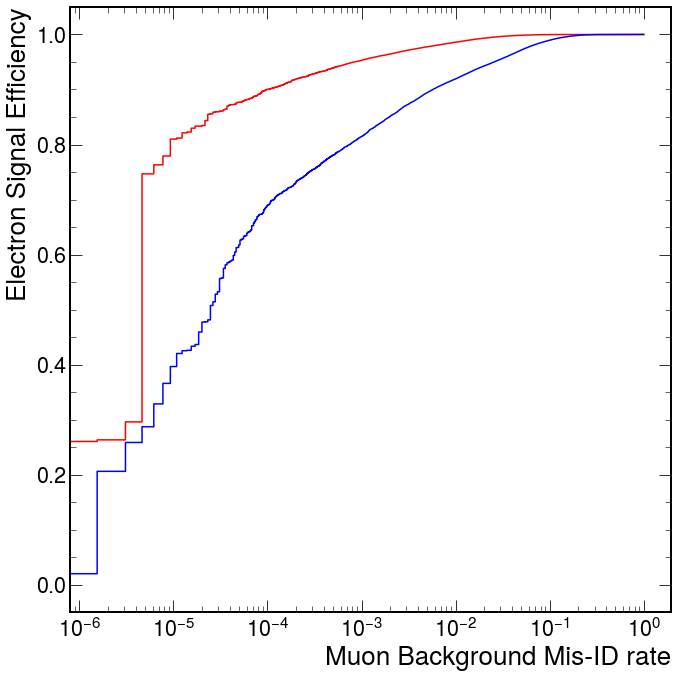

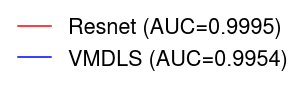

In [ ]:
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Electron Signal Efficiency", y_label="Muon Background Rejection", mode='rejection', legend=None)
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Electron Signal Efficiency", y_label="Muon Background Rejection", mode='rejection', x_lim=(0.8,1), legend=None)
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Muon Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency', x_lim=(0,0.01), legend=None)
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Muon Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency', x_log=True, legend=None)
l_fig, l_ax = plot_legend(ax)

###  for fixed 0.1% muon mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds that reject 99.9% of muons and apply cut to all events

In [ ]:
help(WatChMaLClassification.cut_with_fixed_efficiency)

Help on function cut_with_fixed_efficiency in module analysis.classification:

cut_with_fixed_efficiency(self, signal_labels, background_labels, efficiency, selection=None, select_labels=None, return_threshold=False)
    Generate array of boolean values indicating whether each event passes a cut defined such that a fixed proportion
    of the selected events pass the cut.
    After taking the subset of `discriminator_values` defined by `selection`, the threshold discriminator value is
    found such that the proportion that are above the threshold is equal to `efficiency`. This cut threshold is then
    used to apply the cut to all events (not just those selected by `selection`) and an array of booleans is
    returned for whether each discriminator value is above the threshold of its corresponding bin. The cut result is
    also stored for use in plotting efficiency profiles.
    
    Parameters
    ----------
    signal_labels: int or sequence of ints
        Set of labels correspond

In [ ]:
muon_rejection = 0.999
muon_efficiency = 1-muon_rejection
resnet_run.cut_with_fixed_efficiency(e_labels, mu_labels, muon_efficiency, select_labels=mu_labels)
vmdls_run.cut_with_fixed_efficiency(e_labels, mu_labels, muon_efficiency, select_labels=mu_labels)

array([ True,  True, False, ...,  True,  True,  True])

### Plot signal efficiency against true momentum, dwall, towall, zenith, azimuth

In [ ]:
help(plot_efficiency_profile)

Help on function plot_efficiency_profile in module analysis.classification:

plot_efficiency_profile(runs, binning, selection=None, select_labels=None, ax=None, fig_size=None, x_label='', y_label='', legend='best', y_lim=None, **plot_args)
    Plot binned efficiencies for a cut applied to a number of classification runs.
    Each run should already have had a cut generated, then in each bin the proportion of events passing the cut is
    calculated as the efficiency and plotted. A selection can be provided to use only a subset of all the values. The
    same binning and selection is applied to each run.
    
    Parameters
    ----------
    runs: sequence of ClassificationRun
        Sequence of runs to plot
    binning: (np.ndarray, np.ndarray)
        Array of bin edges and array of bin indices, returned from `analysis.utils.binning.get_binning`.
    selection: indexing expression, optional
        Selection of the values to use in calculating the efficiencies (by default use each r

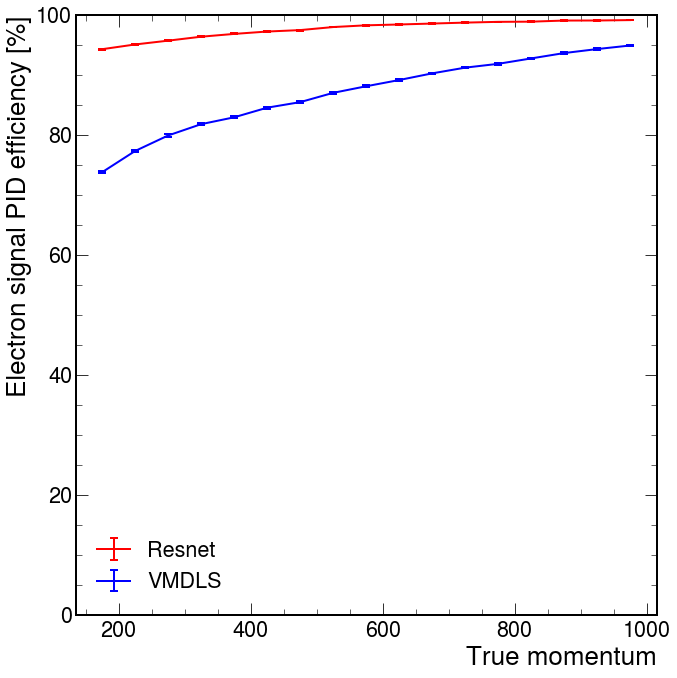

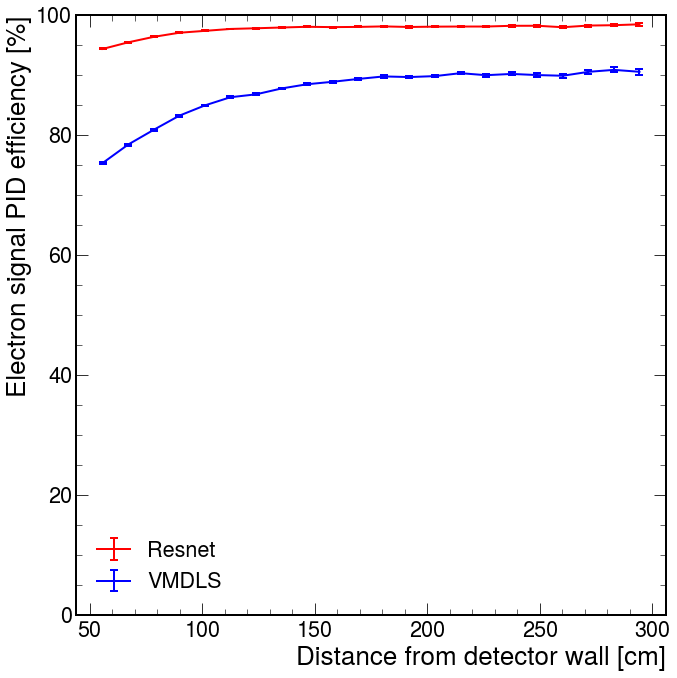

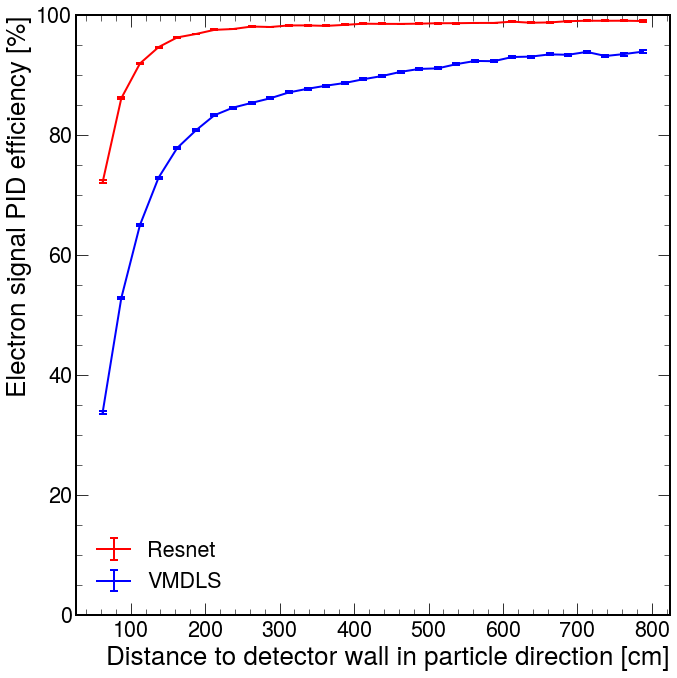

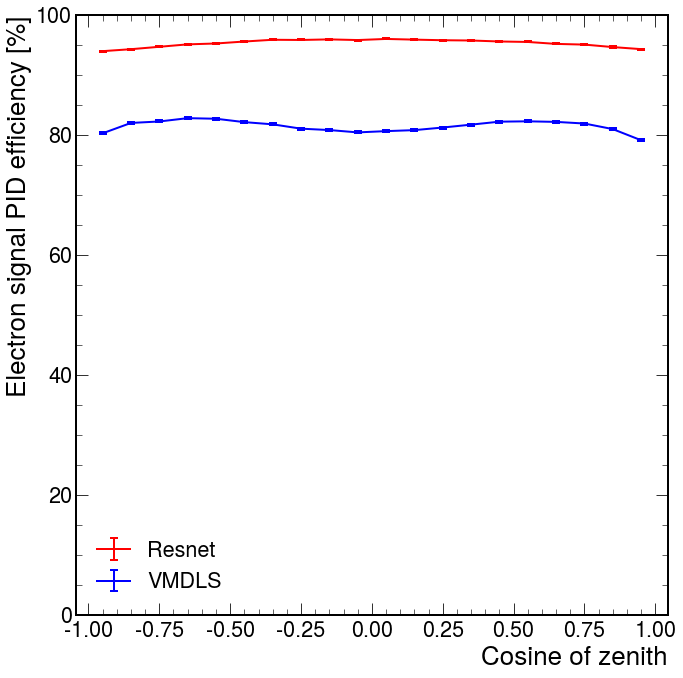

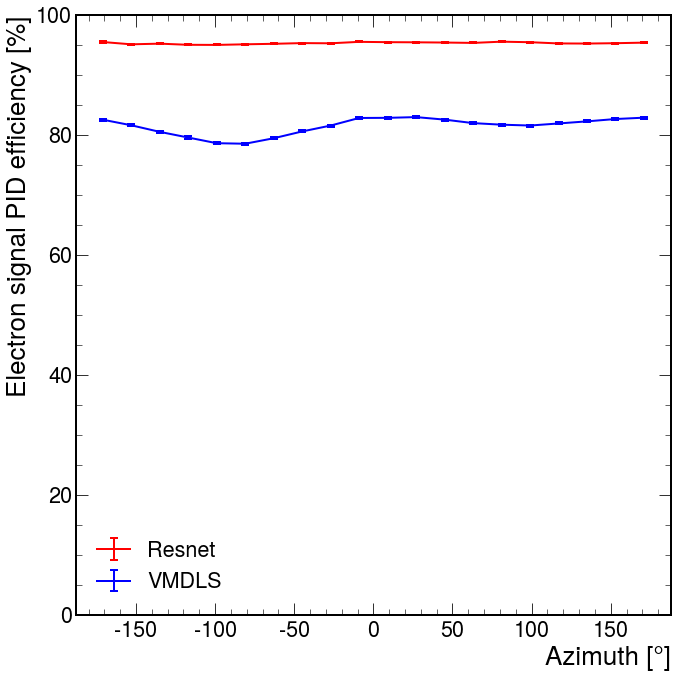

In [ ]:
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], mom_binning, select_labels=e_labels, x_label="True momentum", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], dwall_binning, select_labels=e_labels, x_label="Distance from detector wall [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], towall_binning, select_labels=e_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], cos_zenith_binning, select_labels=e_labels, x_label="Cosine of zenith", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], azimuth_binning, select_labels=e_labels, x_label="Azimuth [°]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(0,100))

### Plot background mis-ID against true momentum, dwall, towall, zenith, azimuth

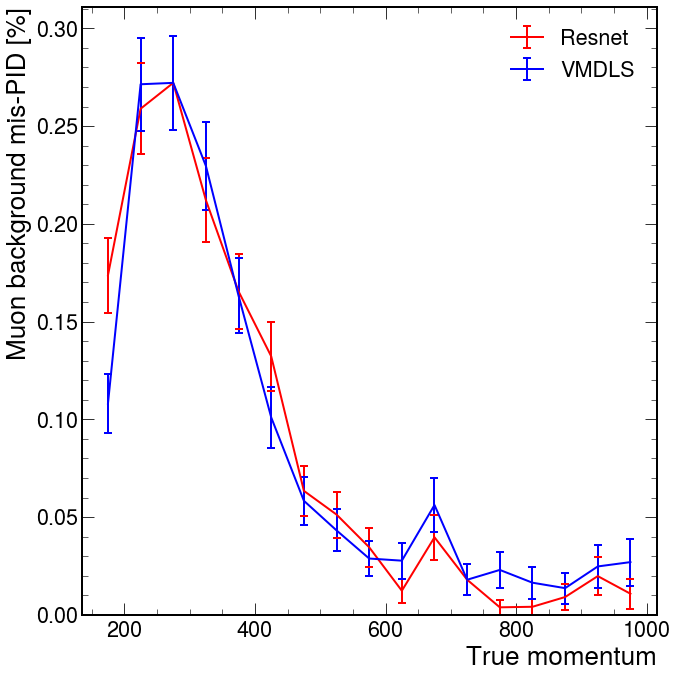

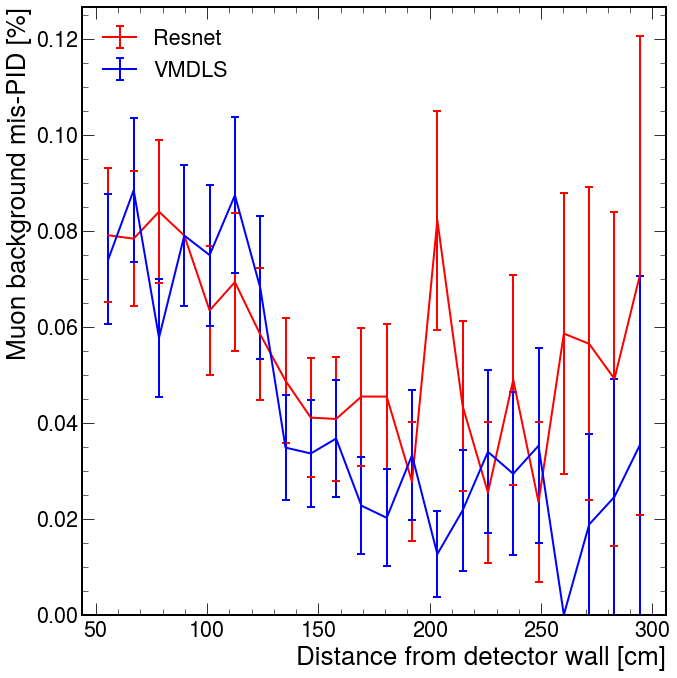

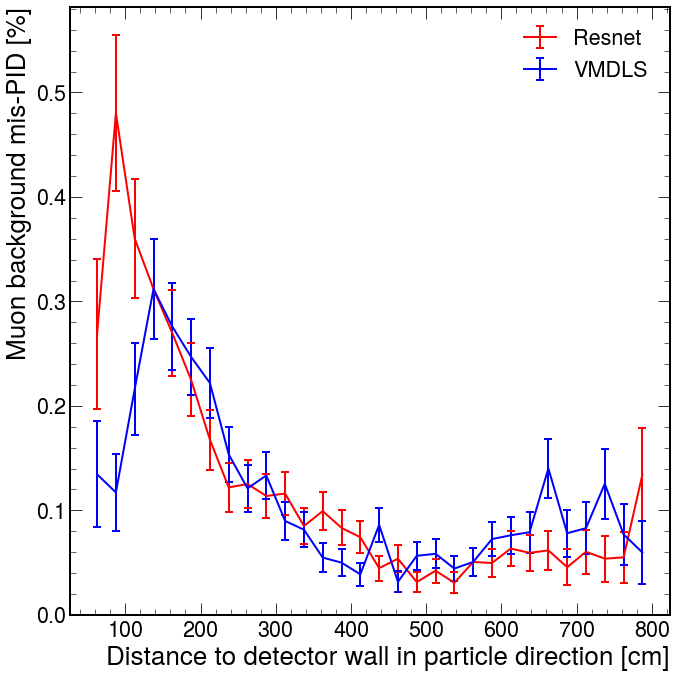

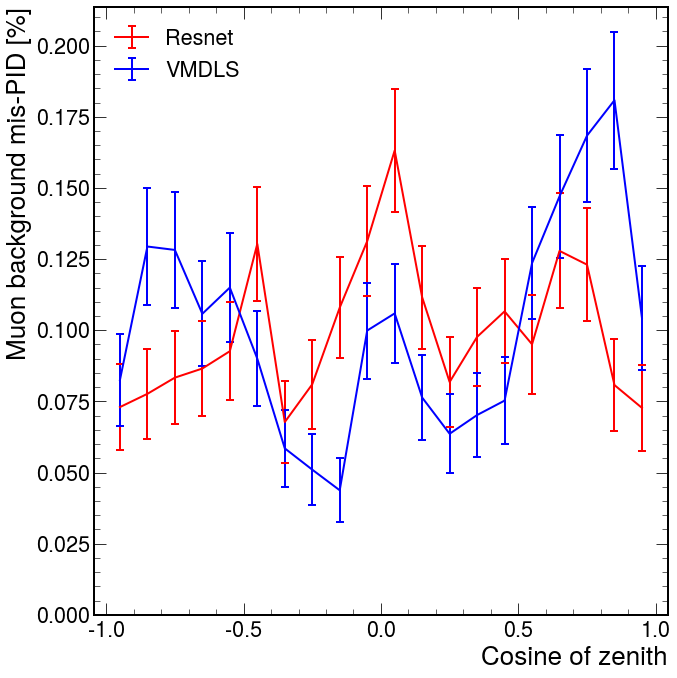

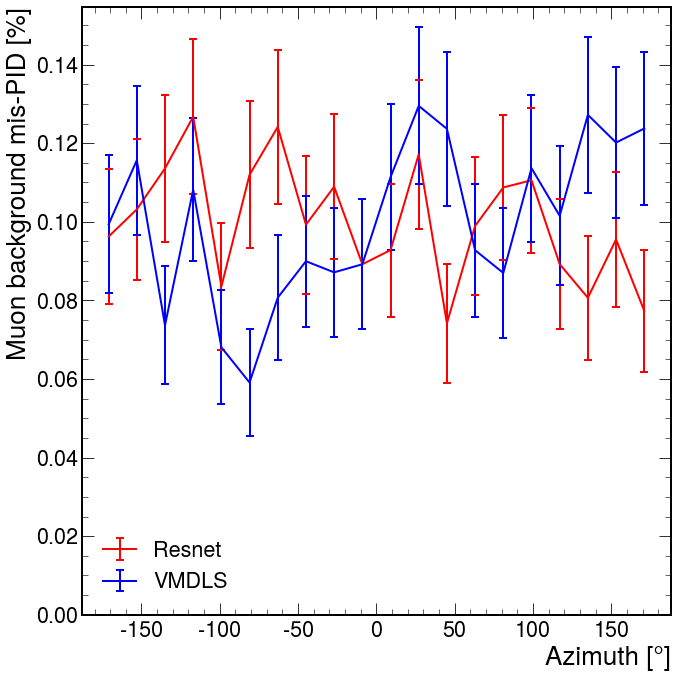

In [ ]:
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], mom_binning, select_labels=mu_labels, x_label="True momentum", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], dwall_binning, select_labels=mu_labels, x_label="Distance from detector wall [cm]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run,  vmdls_run], towall_binning, select_labels=mu_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run, vmdls_run ], cos_zenith_binning, select_labels=mu_labels, x_label="Cosine of zenith", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run, vmdls_run], azimuth_binning, select_labels=mu_labels, x_label="Azimuth [°]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)